In [1]:
!pip install PyPortfolioOpt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 5.1 MB/s eta 0:00:00


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Retorno total: 2538.52%
 Volatilidad anual: 20.86%
 Sharpe ratio anualizado: 1.57
 Max Drawdown: 36.07%


/tmp/ipython-input-3062393040.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_return = (portfolio_value[-1] / initial_capital - 1) * 100


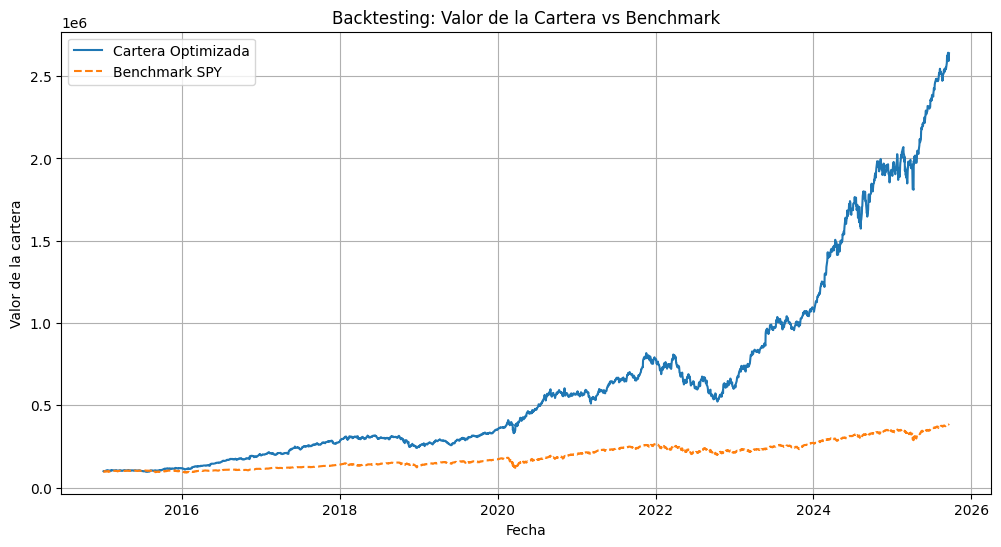

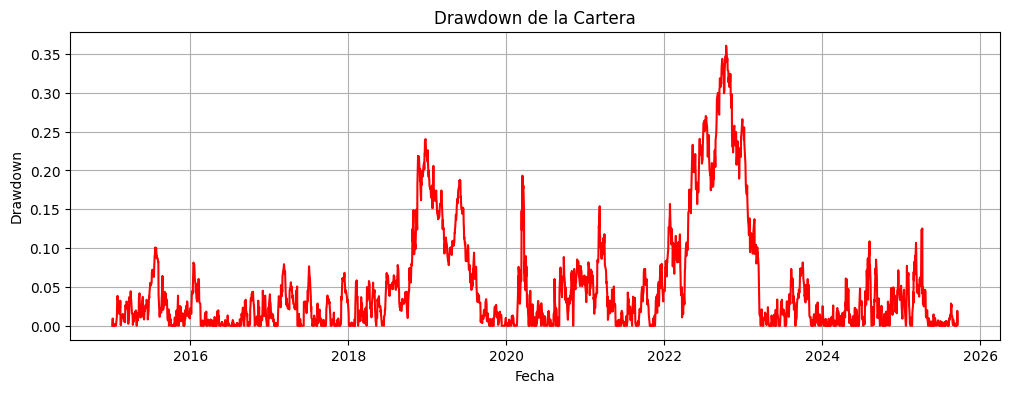

In [3]:
# ================================================
# BACKTESTING DE LA CARTERA OPTIMIZADA
# ================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import discrete_allocation
from pathlib import Path

# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

# Directorios
BASE = Path('/content/drive/MyDrive/ProyectoCartera')
PROCESSED_DIR = BASE / 'data' / 'processed'

# 1️ Cargar precios limpios
prices = pd.read_csv(PROCESSED_DIR / 'prices.csv', index_col=0, parse_dates=True)

# Limpiar el índice y los datos numéricos en el DataFrame de precios
prices.index = pd.to_datetime(prices.index, errors='coerce') # Convierte el índice a DatetimeIndex, los valores no válidos se convierten a NaT
prices = prices[prices.index.notna()] # Elimina filas donde el índice no es una fecha válida

prices = prices.apply(pd.to_numeric, errors='coerce') # Convierte todas las columnas a numérico, los valores no numéricos se convierten a NaN
prices = prices.dropna(how='all') # Elimina filas que son completamente NaN después de la conversión (si hubiera alguna)

# 2️ Calcular retornos diarios
returns = prices.pct_change().dropna(how='all')

# 3️ Definir pesos de la cartera optimizada (ejemplo de última optimización)
weights = {
    'AMZN': 0.0242,
    'GLD': 0.5789,
    'MSFT': 0.0276,
    'NVDA': 0.3692
    # resto activos con 0 peso
}

# Asegurar que todos los tickers estén en el DataFrame
weights = {k:v for k,v in weights.items() if k in returns.columns}

# 4️ Simular valor de la cartera
initial_capital = 100_000  # € o $ inicial
weights_array = np.array([weights.get(ticker, 0) for ticker in returns.columns])
portfolio_daily_returns = (returns * weights_array).sum(axis=1)
portfolio_value = initial_capital * (1 + portfolio_daily_returns).cumprod()

# 5️ Simular un benchmark pasivo (SPY 100%)
benchmark_value = initial_capital * (1 + returns['SPY']).cumprod()

# 6️ Calcular métricas
total_return = (portfolio_value[-1] / initial_capital - 1) * 100
annual_vol = portfolio_daily_returns.std() * np.sqrt(252) * 100
sharpe = (portfolio_daily_returns.mean() * 252) / (portfolio_daily_returns.std() * np.sqrt(252))
max_drawdown = ((portfolio_value.cummax() - portfolio_value) / portfolio_value.cummax()).max() * 100

# 7️ Mostrar resultados
print(f" Retorno total: {total_return:.2f}%")
print(f" Volatilidad anual: {annual_vol:.2f}%")
print(f" Sharpe ratio anualizado: {sharpe:.2f}")
print(f" Max Drawdown: {max_drawdown:.2f}%")

# 8️ Gráficos
plt.figure(figsize=(12,6))
plt.plot(portfolio_value, label="Cartera Optimizada")
plt.plot(benchmark_value, label="Benchmark SPY", linestyle='--')
plt.title("Backtesting: Valor de la Cartera vs Benchmark")
plt.ylabel("Valor de la cartera")
plt.xlabel("Fecha")
plt.legend()
plt.grid(True)
plt.show()

# Opcional: gráfica de drawdown
drawdown = (portfolio_value.cummax() - portfolio_value) / portfolio_value.cummax()
plt.figure(figsize=(12,4))
plt.plot(drawdown, color='red')
plt.title("Drawdown de la Cartera")
plt.ylabel("Drawdown")
plt.xlabel("Fecha")
plt.grid(True)
plt.show()